In [479]:
import pandas as pd
import numpy as np
import json, requests
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
scenario = 0

## Loan Limits by County 2022: 
Data is from [The Exchange by Fannie Mae](https://theexchange.fanniemae.com), a data resource provided from Fannie, one of the Government Sponsered Enterprises (GSE) of the mortgage industry. `Loan Limits` are set every year by the Federal Housing Finance Agency (FHFA) on the unit size level (one unit, two unit, three unit, four unit). Loan limits set a maximum dollar amount on loans that Fannie Mae and Freddie Mac (the GSEs) are willing to buy or guarantee. If a loan exceeds this limit, a borrower cannot use a conventional loan, and they will have to apply for a Jumbo loan (yes, that's the real name!). Loan limits are set annually based on the market to prevent overborrowing and foreclosures. 

## CBSA Number and FIPs Code:

### CBSA... 
stands for Core-Based Statistical Area and is defined as a U.S. geographic area that consists of one or more counties connected by an urban center of at least 10,000 people plus adjacent counties. It is a unique identifier to locate urban areas defined by the Office of Management and Budget (OMB). Here is a resource on [FIPS Metropolitan Area CBSA Codes](https://www2.census.gov/programs-surveys/cps/methodology/2015%20Geography%20Cover.pdf). If `CBSA Code = 99999`, the CBSA Name is `"Not in a metro/micro area"`.

### FIPS Code...
are numbers that uniquely define geographical areas. Here is more information of [FIPS codes](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt). 


In [460]:
#Open Loan Limit JSON, convert to data frame
f = open('FannieExchangeLoanLimitsAll.json', 'r')

data = pd.read_json('FannieExchangeLoanLimitsAll.json')
json = json.loads(f.read())
f.close()
data = pd.DataFrame(json)
data

,stateCode,countyName,reportingYear,cbsaNumber,fipsCode,issuers
0,AL,Autauga County,20220101,33860,01001,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."
1,AL,Baldwin County,20220101,19300,01003,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."
2,AL,Barbour County,20220101,21640,01005,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."
3,AL,Bibb County,20220101,13820,01007,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."
4,AL,Blount County,20220101,13820,01009,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."
...,...,...,...,...,...,...
3228,PR,Yabucoa Municipality,20220101,41980,72151,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."
3229,PR,Yauco Municipality,20220101,49500,72153,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."
3230,VI,Saint Croix Island,20220101,99999,78010,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."
3231,VI,Saint John Island,20220101,99999,78020,"{'issuer': [{'issuerType': 'FHFA', 'oneUnitLim..."


In [461]:
#Explore issuer column, see keys and values inside
Explore_Issuer = data['issuers'].apply(lambda x: x['issuer'][0])[0]
Explore_Issuer

{'issuerType': 'FHFA',
 'oneUnitLimit': 647200,
 'twoUnitLimit': 828700,
 'threeUnitLimit': 1001650,
 'fourUnitLimit': 1244850}

In [462]:
#Create new columns with key:value pairs in Issuers column, delete original column
data['Issuer Type'] = data['issuers'].apply(lambda x: x['issuer'][0]['issuerType'])
data['One Unit Limit'] = data['issuers'].apply(lambda x: x['issuer'][0]['oneUnitLimit'])
data['Two Unit Limit'] = data['issuers'].apply(lambda x: x['issuer'][0]['twoUnitLimit'])
data['Three Unit Limit'] = data['issuers'].apply(lambda x: x['issuer'][0]['threeUnitLimit'])
data['Four Unit Limit'] = data['issuers'].apply(lambda x: x['issuer'][0]['fourUnitLimit'])
data = data.drop(columns = ['issuers'])
data

,stateCode,countyName,reportingYear,cbsaNumber,fipsCode,Issuer Type,One Unit Limit,Two Unit Limit,Three Unit Limit,Four Unit Limit
0,AL,Autauga County,20220101,33860,01001,FHFA,647200,828700,1001650,1244850
1,AL,Baldwin County,20220101,19300,01003,FHFA,647200,828700,1001650,1244850
2,AL,Barbour County,20220101,21640,01005,FHFA,647200,828700,1001650,1244850
3,AL,Bibb County,20220101,13820,01007,FHFA,647200,828700,1001650,1244850
4,AL,Blount County,20220101,13820,01009,FHFA,647200,828700,1001650,1244850
...,...,...,...,...,...,...,...,...,...,...
3228,PR,Yabucoa Municipality,20220101,41980,72151,FHFA,647200,828700,1001650,1244850
3229,PR,Yauco Municipality,20220101,49500,72153,FHFA,647200,828700,1001650,1244850
3230,VI,Saint Croix Island,20220101,99999,78010,FHFA,970800,1243050,1502475,1867275
3231,VI,Saint John Island,20220101,99999,78020,FHFA,970800,1243050,1502475,1867275


In [463]:
#Format year column, pull summary statistics on the data
data['reportingYear'] = pd.to_datetime(data['reportingYear'], format='%Y%m%d')

summary = data.describe().round(0)
summary = summary.style.format('{:,}')
summary

,One Unit Limit,Two Unit Limit,Three Unit Limit,Four Unit Limit
count,"3,233.0","3,233.0","3,233.0","3,233.0"
mean,"659,056.0","843,877.0","1,019,996.0","1,267,650.0"
std,"58,400.0","74,773.0","90,379.0","112,322.0"
min,"647,200.0","828,700.0","1,001,650.0","1,244,850.0"
25%,"647,200.0","828,700.0","1,001,650.0","1,244,850.0"
50%,"647,200.0","828,700.0","1,001,650.0","1,244,850.0"
75%,"647,200.0","828,700.0","1,001,650.0","1,244,850.0"
max,"970,800.0","1,243,050.0","1,502,475.0","1,867,275.0"


### Statistical Observations: 
- Mean and Std Dev increase as Unit size increases.
- Most of the Loan Limits are the Minimum (75% + ).
- The dataset seems to be complete. All Unit sizes have 3,233 values, which is the number of rows in the dataset.

### Are there multiple counties with the same name?

In [464]:
#counts entries by counties, are there multiple counties with the same names?
county_counts = {}

for entry in data['countyName']:
    if entry in county_counts.keys():
        county_counts[entry] = county_counts[entry] + 1
    else:
        county_counts[entry] = 1

county_counts

{'Autauga County': 1,
 'Baldwin County': 2,
 'Barbour County': 2,
 'Bibb County': 2,
 'Blount County': 2,
 'Bullock County': 1,
 'Butler County': 8,
 'Calhoun County': 11,
 'Chambers County': 2,
 'Cherokee County': 8,
 'Chilton County': 1,
 'Choctaw County': 3,
 'Clarke County': 5,
 'Clay County': 18,
 'Cleburne County': 2,
 'Coffee County': 3,
 'Colbert County': 1,
 'Conecuh County': 1,
 'Coosa County': 1,
 'Covington County': 2,
 'Crenshaw County': 1,
 'Cullman County': 1,
 'Dale County': 1,
 'Dallas County': 5,
 'DeKalb County': 6,
 'Elmore County': 2,
 'Escambia County': 2,
 'Etowah County': 1,
 'Fayette County': 11,
 'Franklin County': 24,
 'Geneva County': 1,
 'Greene County': 14,
 'Hale County': 2,
 'Henry County': 10,
 'Houston County': 5,
 'Jackson County': 23,
 'Jefferson County': 25,
 'Lamar County': 4,
 'Lauderdale County': 3,
 'Lawrence County': 11,
 'Lee County': 12,
 'Limestone County': 2,
 'Lowndes County': 3,
 'Macon County': 6,
 'Madison County': 19,
 'Marengo County'

### How many urban centers (CBSA #s) are in each state?

In [465]:
#csbaNumbers by State, i.e. How many urban centers are in each state?
data.groupby('stateCode')['cbsaNumber'].count().to_dict()

{'AK': 29,
 'AL': 67,
 'AR': 75,
 'AS': 5,
 'AZ': 15,
 'CA': 58,
 'CO': 64,
 'CT': 8,
 'DC': 1,
 'DE': 3,
 'FL': 67,
 'GA': 159,
 'GU': 1,
 'HI': 5,
 'IA': 99,
 'ID': 44,
 'IL': 102,
 'IN': 92,
 'KS': 105,
 'KY': 120,
 'LA': 64,
 'MA': 14,
 'MD': 24,
 'ME': 16,
 'MI': 83,
 'MN': 87,
 'MO': 115,
 'MP': 4,
 'MS': 82,
 'MT': 56,
 'NC': 100,
 'ND': 53,
 'NE': 93,
 'NH': 10,
 'NJ': 21,
 'NM': 33,
 'NV': 17,
 'NY': 62,
 'OH': 88,
 'OK': 77,
 'OR': 36,
 'PA': 67,
 'PR': 78,
 'RI': 5,
 'SC': 46,
 'SD': 66,
 'TN': 95,
 'TX': 254,
 'UT': 29,
 'VA': 133,
 'VI': 3,
 'VT': 14,
 'WA': 39,
 'WI': 72,
 'WV': 55,
 'WY': 23}

### Investigate Non-Metro CBSA Code = 99999

Let's find all the NonMetro counties where the One Unit Loan Limit is greater than the One Unit Limit mean of the overall dataset and slice the new dataset to exclude irrelevant values. 

In [466]:
NonMetrodata = data[data['cbsaNumber'] == '99999']
NonMetrodata.describe()
NonMetroSum = Metrodata.describe().round(0)
NonMetroSum = NonMetroSum.style.format('{:,}')
NonMetroSum

,One Unit Limit,Two Unit Limit,Three Unit Limit,Four Unit Limit
count,"1,916.0","1,916.0","1,916.0","1,916.0"
mean,"662,081.0","847,749.0","1,024,676.0","1,273,466.0"
std,"64,227.0","82,232.0","99,396.0","123,527.0"
min,"647,200.0","828,700.0","1,001,650.0","1,244,850.0"
25%,"647,200.0","828,700.0","1,001,650.0","1,244,850.0"
50%,"647,200.0","828,700.0","1,001,650.0","1,244,850.0"
75%,"647,200.0","828,700.0","1,001,650.0","1,244,850.0"
max,"970,800.0","1,243,050.0","1,502,475.0","1,867,275.0"


In [467]:
#Filter the NonMetro Data for the counties where the One Unit Limit is greater than the overall One Unit Limit Mean
BigLimitNonMetro = NonMetrodata[NonMetrodata['One Unit Limit'] > data['One Unit Limit'].mean()]
BigLimitNonMetro = BigLimitNonMetro.loc[:,'stateCode':'One Unit Limit']
BigLimitNonMetro

,stateCode,countyName,reportingYear,cbsaNumber,fipsCode,Issuer Type,One Unit Limit
67,AK,Aleutians East Borough,2022-01-01,99999,02013,FHFA,970800
68,AK,Aleutians West Census Area,2022-01-01,99999,02016,FHFA,970800
70,AK,Bethel Census Area,2022-01-01,99999,02050,FHFA,970800
71,AK,Bristol Bay Borough,2022-01-01,99999,02060,FHFA,970800
72,AK,Denali Borough,2022-01-01,99999,02068,FHFA,970800
73,AK,Dillingham Census Area,2022-01-01,99999,02070,FHFA,970800
75,AK,Haines Borough,2022-01-01,99999,02100,FHFA,970800
76,AK,Hoonah–Angoon Census Area,2022-01-01,99999,02105,FHFA,970800
78,AK,Kenai Peninsula Borough,2022-01-01,99999,02122,FHFA,970800
80,AK,Kodiak Island Borough,2022-01-01,99999,02150,FHFA,970800


### Exploring GA data...

In [468]:
#Filter for all GA counties, sort DF, select first and last
GAdata = data[data['stateCode'] == 'GA']
GAsort = GAdata.sort_values('countyName', ascending = False)

last_GA = GAsort.iloc[0]
last_GA

first_GA = GAsort.iloc[-1]
first_GA

#Counts of Metro to Non Metro CBSA Codes in GA
counts = {'Metro': 0, 'NonMetro': 0}
for entry in GAdata['cbsaNumber']:
    if entry == '99999':
        counts['NonMetro'] = counts['NonMetro'] + 1
    else:
        counts['Metro'] = counts['Metro'] + 1
        
Percent_GA_Metro = 'Percent Metro GA: ' + str(round((counts['Metro']*100)/(counts['Metro']+counts['NonMetro']), 2)) + '%'
Percent_GA_Metro

'Percent Metro GA: 66.04%'

### 18 Clay Counties, oh my!

In [469]:
#Select all counties named "Clay County", Find the mean Loan Limit by Unit size
clay = data[data['countyName'] == 'Clay County']

one_mean = clay['One Unit Limit'].mean()
two_mean = clay['Two Unit Limit'].mean()
three_mean = clay['Three Unit Limit'].mean()
four_mean = clay['Four Unit Limit'].mean()

means = [one_mean, two_mean, three_mean, four_mean]

rows = ['One Unit', 'Two Unit', 'Three Unit', 'Four Unit']
cols = ['Mean Loan Limit']

df = pd.DataFrame(means, columns = cols)
df.index = rows
df['Mean Loan Limit'] = df['Mean Loan Limit'].round(0)
df.style.format('{:,}')
df.style.set_caption('Mean Loan Limits: All 18 Clay Counties')
df

,Mean Loan Limit
One Unit,647200.0
Two Unit,828700.0
Three Unit,1001650.0
Four Unit,1244850.0


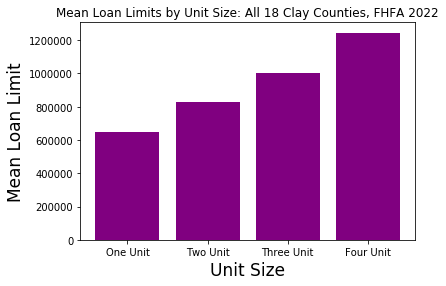

In [470]:
x = df.index
y = list(df['Mean Loan Limit'])
plt.bar(x, y, color = 'purple')
plt.ylabel('Mean Loan Limit', fontsize = 17)
plt.xlabel('Unit Size', fontsize = 17)
plt.title('Mean Loan Limits by Unit Size: All 18 Clay Counties, FHFA 2022')
plt.show()

In [477]:
#Save as excel file
data.to_excel(r'/Users/jess/Desktop/Loan Limits Clean Data.xlsx')

In [453]:
#Graveyard
#one_med = data.groupby('stateCode')['One Unit Limit'].median().to_dict()
#one_mean = data.groupby('stateCode')['One Unit Limit'].mean().to_dict()
#two_med = data.groupby('stateCode')['Two Unit Limit'].median().to_dict()
#two_mean = data.groupby('stateCode')['Two Unit Limit'].mean().to_dict()
#three_med = data.groupby('stateCode')['Three Unit Limit'].median().to_dict()
#three_mean = data.groupby('stateCode')['Three Unit Limit'].mean().to_dict()
#four_mean = data.groupby('stateCode')['Four Unit Limit'].mean().to_dict()
#four_med = data.groupby('stateCode')['Four Unit Limit'].median().to_dict()

#cols = ['State Code', 'One Unit Limit Mean', 'One Unit Limit Median', 'Two Unit Limit Mean', 'Two Unit Limit Median', 'Three Unit Limit Mean', 'Three Unit Limit Median', 'Four Unit Limit Mean', 'Four Unit Limit Median']

#zips = zip(one_med.keys(), one_mean.values(), one_med.values(),two_mean.values(), two_med.values(), three_mean.values(), three_med.values(),four_mean.values(), four_med.values())

#df = pd.DataFrame(zips, columns = cols)
#df